In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
gdp_pc = pd.read_csv('merged_gdp_pc.csv')
gdp_g_pc = pd.read_csv('merged_gdp_g_pc.csv')
gdp_ppp = pd.read_csv('merged_gdp_ppp_pc.csv')

In [83]:
total_gdp_df = gdp_pc.copy()
total_gdp_df['GDP Growth'] = gdp_g_pc['GDP']
total_gdp_df['GDP PPP'] = gdp_ppp['GDP']

Text(0.5, 1.0, 'Correlation Between Variables; Alcohol Types and GDP Metric')

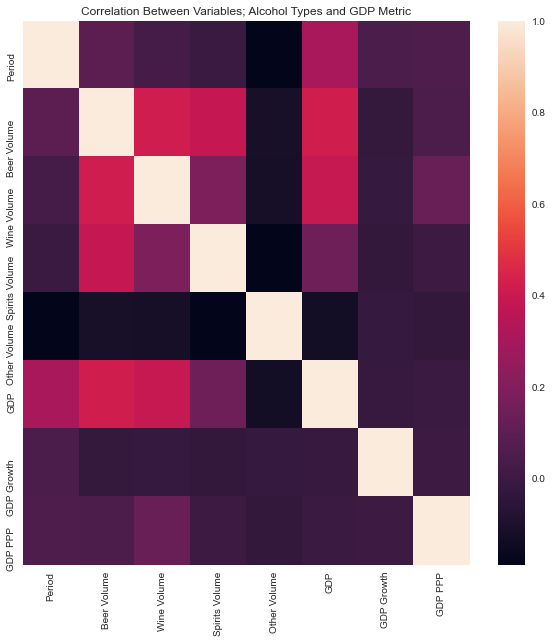

In [91]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

ax = sns.heatmap(total_gdp_df.drop(columns=['All Types Volume','Unnamed: 0']).corr())
ax.set_title('Correlation Between Variables; Alcohol Types and GDP Metric')

Assign a score to the GDP of a country on a scale of 1-5 - this works for gdp_pc & gdp_ppp

1 - poor

2 - ok

3 - good

In [93]:
# use pd.qcut as discretises the data as the data is imbalanced

gdp_pc['score'] = pd.qcut(gdp_pc['GDP'], 3, labels=[0,1,2])

gdp_ppp['score'] = pd.qcut(gdp_ppp['GDP'], 3, labels=[0,1,2])

gdp_g_pc['score'] = pd.qcut(gdp_g_pc['GDP'], 3, labels=[0,1,2])


In [94]:
gdp_pc['score'].value_counts()

2    2177
0    2177
1    2176
Name: score, dtype: int64

In [95]:
gdp_g_pc['score'].value_counts()

0    2117
2    2116
1    2116
Name: score, dtype: int64

In [96]:
gdp_ppp['score'].value_counts()

2    1551
1    1551
0    1551
Name: score, dtype: int64

In [97]:
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from scipy.stats import randint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

In [98]:
def Rforest(df):
    X = df.drop(columns=['GDP', 'score', 'Unnamed: 0', 'Location', 'Period'])
    y = df['score']

    df_max_scaled = X.copy()
  
    for column in df_max_scaled.columns:
        df_max_scaled[column] = df_max_scaled[column]  / df_max_scaled[column].abs().max()
        
    X_norm = df_max_scaled

    X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2)

    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    accuracy_test = accuracy_score(y_test, y_pred)
    accuracy_train = rf.score(X_train, y_train)
    print('Accuracy on Test', accuracy_test)
    print("\n",'Accuracy on Train', accuracy_train)

    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    scores = cross_val_score(rf, X, y, cv=cv)

    print("\n", "%0.2f accuracy, after cross validation, with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

    print("\n", classification_report(y_test, y_pred))

    return y_test, y_pred, rf

In [108]:
y_test, y_pred, rf = Rforest(gdp_ppp)

Accuracy on Test 0.8635875402792696

 Accuracy on Train 0.9846856528747985

 0.86 accuracy, after cross validation, with a standard deviation of 0.01

               precision    recall  f1-score   support

           0       0.90      0.90      0.90       325
           1       0.85      0.81      0.83       325
           2       0.85      0.89      0.87       281

    accuracy                           0.86       931
   macro avg       0.86      0.86      0.86       931
weighted avg       0.86      0.86      0.86       931



The model is overfitting as the peformance on the training data is greater than that of the test data

Text(0.5, 1.0, 'RForest Confusion Matrix')

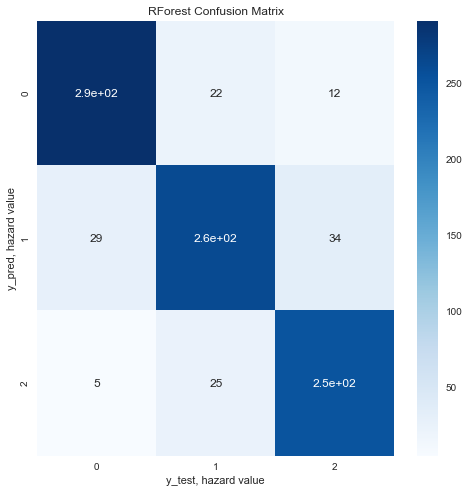

In [109]:
conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(1, 1, figsize=(8,8))

ax = sns.heatmap(conf_mat, annot=True, cmap='Blues')
ax.set_xlabel('y_test, hazard value')
ax.set_ylabel('y_pred, hazard value')
ax.set_title('RForest Confusion Matrix')

Text(0.5, 1.0, 'Predicted Score Values')

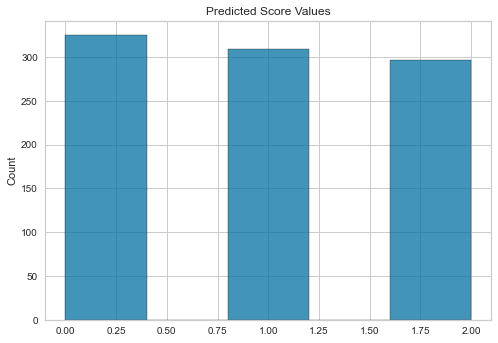

In [110]:
ax = sns.histplot(y_pred, bins=5)
ax.set_title('Predicted Score Values')

In [186]:
def Hyperparam(df):

    X = df.drop(columns=['GDP', 'score', 'Unnamed: 0', 'Location', 'Period'])
    y = df['score']

    df_max_scaled = X.copy()
  
    for column in df_max_scaled.columns:
        df_max_scaled[column] = df_max_scaled[column]  / df_max_scaled[column].abs().max()
            
    X_norm = df_max_scaled

    X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2)
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2500, num = 10)]
    max_features = ['auto', 'sqrt', 'log2']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}

    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 5, verbose=2, random_state=42, n_jobs = -1)
    rf_random.fit(X_train, y_train)
    params = rf_random.best_params_
    rf1 = RandomForestClassifier(**params)
    rf1.fit(X_train, y_train)
    y_pred1 = rf1.predict(X_test)
    accuracy1 = accuracy_score(y_test, y_pred1)
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    scores1 = cross_val_score(rf1, X, y, cv=cv)
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores1.mean(), scores1.std()))
    feature_imp = pd.Series(rf1.feature_importances_, index=X.columns).sort_values(ascending=True)
    print(classification_report(y_test, y_pred1))

    return feature_imp, [params]

In [187]:
feature_imp, params = Hyperparam(gdp_ppp)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.81 accuracy with a standard deviation of 0.01
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       187
           1       0.75      0.75      0.75       178
           2       0.85      0.77      0.81       198
           3       0.82      0.81      0.82       189
           4       0.86      0.89      0.88       179

    accuracy                           0.82       931
   macro avg       0.82      0.82      0.82       931
weighted avg       0.82      0.82      0.82       931



In [188]:
params[0]

{'n_estimators': 1700,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': False}

<AxesSubplot:>

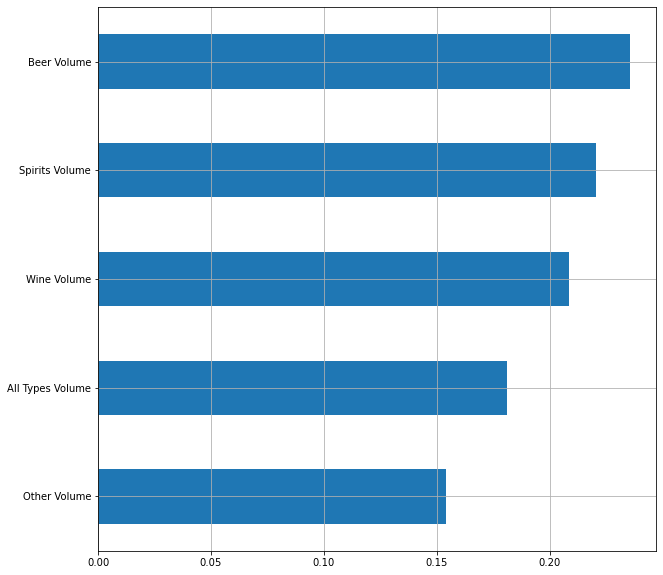

In [189]:
feature_imp.plot(kind='barh', grid=True, figsize=(10,10))

Unsupervised

In [38]:
!pip install yellowbrick

In [42]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [12]:
# run this - if threadpool ctl is not v3.2.0, run next cell

# import sklearn
# sklearn.show_versions()

In [10]:
#  !pip install threadpoolctl -U

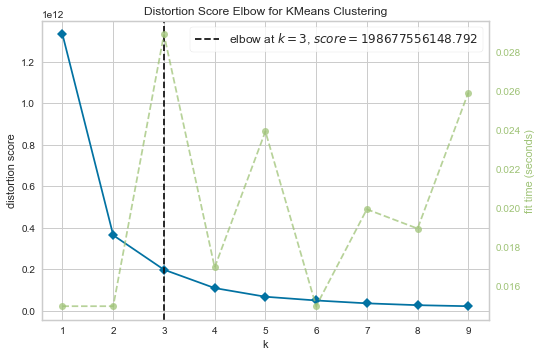

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [52]:
# quick kmeans model for elbow method

df = gdp_pc

X = df.drop(columns=['Period', 'Unnamed: 0', 'score', 'Location'])
X = X.to_numpy()
y = df['score'].to_numpy()

kmeans = KMeans(random_state=0, n_init='auto')
vis = KElbowVisualizer(kmeans, k=(1,10), metric='distortion', timings=True)

vis.fit(X)
vis.show()

In [67]:
# using elbow method set value to n=3

df = gdp_ppp

X = df.drop(columns=['Period', 'Unnamed: 0', 'score', 'Location'])
X = X.to_numpy()
y = df['score'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train_norm = preprocessing.normalize(X_train)
X_test_norm = preprocessing.normalize(X_test)

kmeans = KMeans(n_clusters = 3, random_state = 0, n_init='auto')
kmeans.fit(X_train_norm)

print("silhouette_score = ", metrics.silhouette_score(X_train, kmeans.labels_))
print("completeness_score = ", metrics.completeness_score(y_train, kmeans.labels_))
print("homogeneity_score = ", metrics.homogeneity_score(y_train, kmeans.labels_))

silhouette_score =  -0.3518805260651014
completeness_score =  0.23517173117981352
homogeneity_score =  0.045754034804964844
